<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/WideResNet/WideResNet8/23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/obiref88/image'
label_directory = '/content/drive/MyDrive/lernig/obiref88/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))


Number of image paths: 300
Number of labels: 300


In [5]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
         transforms.RandomRotation(degrees=[-5, 5]),
         transforms.ColorJitter(brightness=0.3, contrast=0.5),
         #A.GaussNoise(var_limit=(10, 50))transformライブラリでないので変換前後で定義しなおさなくてはならない,
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [6]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
num_epochs=200
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [9]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [10]:
from torchvision.models import wide_resnet50_2
net =wide_resnet50_2(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
directory_path = os.path.join(base_path, folder_name)
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 169MB/s]


In [11]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

Length of image_paths: 300
Length of labels: 300


==========Cross Validation Fold 1==========
trainLoss: 0.7258 Acc: 0.4000
valLoss: 0.8721 Acc: 0.2333
trainLoss: 0.7290 Acc: 0.4208
valLoss: 0.8849 Acc: 0.2167
trainLoss: 0.7210 Acc: 0.4292
valLoss: 0.8838 Acc: 0.2167
trainLoss: 0.7236 Acc: 0.4333
valLoss: 0.8304 Acc: 0.2167
trainLoss: 0.7162 Acc: 0.4417
valLoss: 0.8286 Acc: 0.2333
trainLoss: 0.7117 Acc: 0.4542
valLoss: 0.7964 Acc: 0.2500
trainLoss: 0.7128 Acc: 0.4875
valLoss: 0.7271 Acc: 0.3833
trainLoss: 0.7101 Acc: 0.4542
valLoss: 0.7423 Acc: 0.2667
trainLoss: 0.7065 Acc: 0.4917
valLoss: 0.7163 Acc: 0.3667
trainLoss: 0.6962 Acc: 0.4917
valLoss: 0.7158 Acc: 0.3833
trainLoss: 0.6980 Acc: 0.5042
valLoss: 0.7020 Acc: 0.4667
trainLoss: 0.6985 Acc: 0.5208
valLoss: 0.6955 Acc: 0.5167
trainLoss: 0.7012 Acc: 0.4917
valLoss: 0.7160 Acc: 0.5000
trainLoss: 0.6965 Acc: 0.5083
valLoss: 0.6841 Acc: 0.4833
trainLoss: 0.6866 Acc: 0.5833
valLoss: 0.7382 Acc: 0.3500
trainLoss: 0.6903 Acc: 0.5292
valLoss: 0.7165 Acc: 0.4167
trainLoss: 0.6783 Acc: 0.550

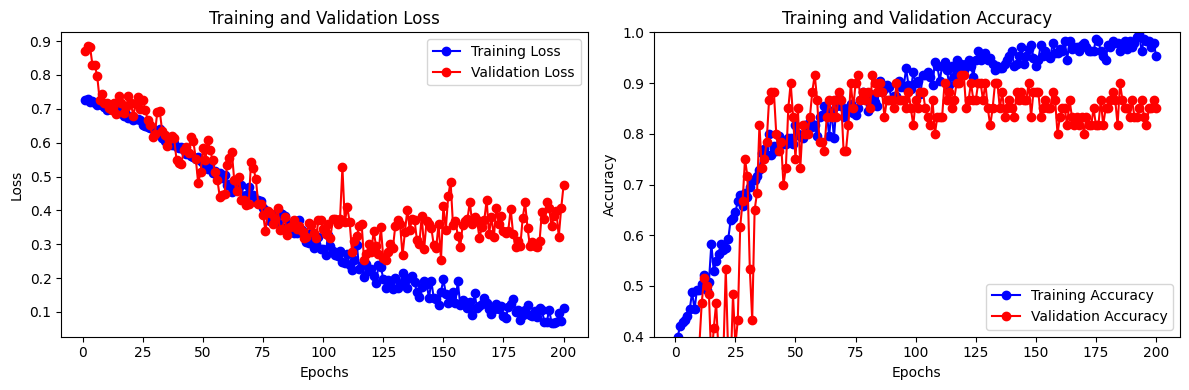

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.97      0.83      0.90        47
         out       0.60      0.92      0.73        13

    accuracy                           0.85        60
   macro avg       0.79      0.88      0.81        60
weighted avg       0.89      0.85      0.86        60

==========Cross Validation Fold 2==========
trainLoss: 0.6383 Acc: 0.7083
valLoss: 0.6241 Acc: 0.7167
trainLoss: 0.5746 Acc: 0.8875
valLoss: 0.5710 Acc: 0.8500
trainLoss: 0.5128 Acc: 0.9417
valLoss: 0.5004 Acc: 0.9833
trainLoss: 0.4718 Acc: 0.9542
valLoss: 0.4359 Acc: 1.0000
trainLoss: 0.4283 Acc: 0.9625
valLoss: 0.4045 Acc: 1.0000
trainLoss: 0.3994 Acc: 0.9583
valLoss: 0.3767 Acc: 1.0000
trainLoss: 0.4037 Acc: 0.9167
valLoss: 0.3287 Acc: 1.0000
trainLoss: 0.3440 Acc: 0.9625
valLoss: 0.2970 Acc: 1.0000
trainLoss: 0.3348 Acc: 0.9375
valLoss: 0.2784 Acc: 1.0000
trainLoss: 0.3181 Acc: 0.9417
valLoss: 0.2560 Acc: 1.0000
trainLoss: 0.3065 Acc: 0

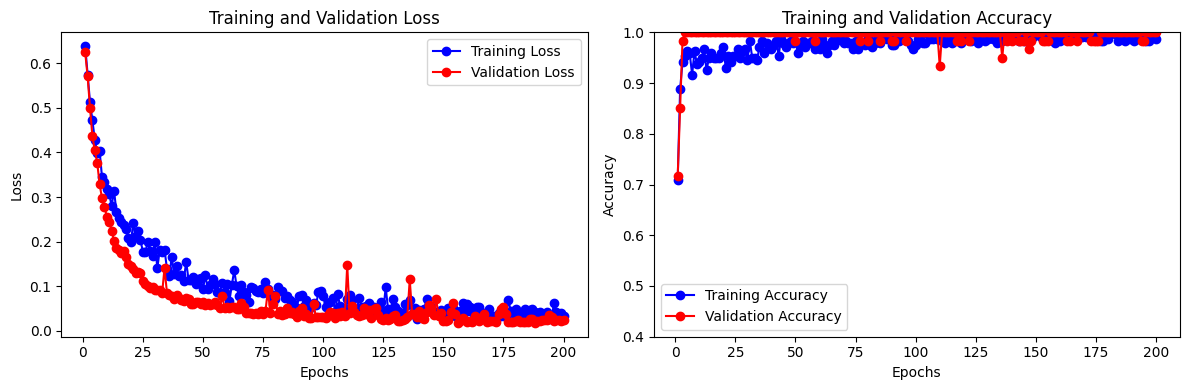

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       1.00      1.00      1.00        48
         out       1.00      1.00      1.00        12

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

==========Cross Validation Fold 3==========
trainLoss: 0.6647 Acc: 0.3917
valLoss: 0.6052 Acc: 0.3000
trainLoss: 0.5511 Acc: 0.9417
valLoss: 0.5234 Acc: 0.8167
trainLoss: 0.4768 Acc: 0.9583
valLoss: 0.4509 Acc: 0.9667
trainLoss: 0.4112 Acc: 0.9917
valLoss: 0.3965 Acc: 0.9667
trainLoss: 0.3665 Acc: 0.9792
valLoss: 0.3495 Acc: 0.9667
trainLoss: 0.3257 Acc: 0.9917
valLoss: 0.3104 Acc: 0.9667
trainLoss: 0.3091 Acc: 0.9917
valLoss: 0.2850 Acc: 0.9667
trainLoss: 0.2739 Acc: 0.9958
valLoss: 0.2621 Acc: 0.9667
trainLoss: 0.2751 Acc: 0.9875
valLoss: 0.2544 Acc: 0.9667
trainLoss: 0.2585 Acc: 0.9750
valLoss: 0.2340 Acc: 0.9667
trainLoss: 0.2195 Acc: 1

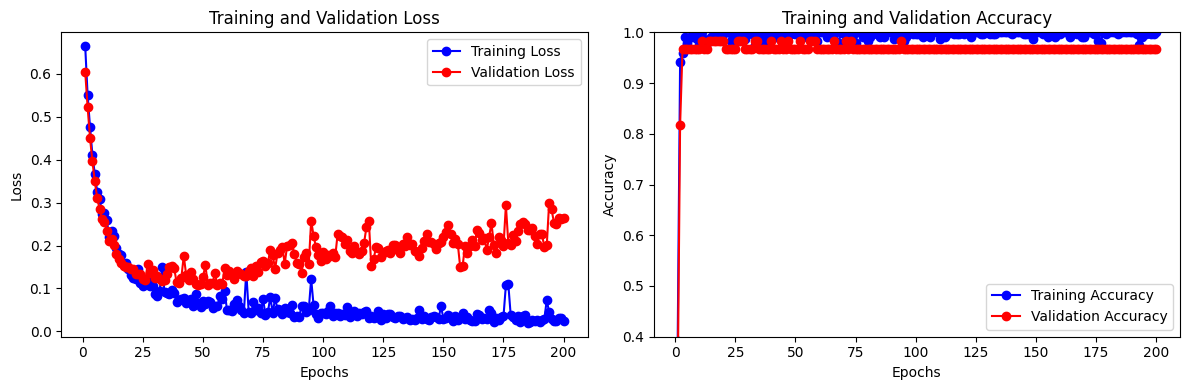

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       1.00      0.95      0.98        42
         out       0.90      1.00      0.95        18

    accuracy                           0.97        60
   macro avg       0.95      0.98      0.96        60
weighted avg       0.97      0.97      0.97        60

==========Cross Validation Fold 4==========
trainLoss: 0.7728 Acc: 0.7042
valLoss: 0.6747 Acc: 0.8333
trainLoss: 0.6168 Acc: 0.7667
valLoss: 0.5397 Acc: 1.0000
trainLoss: 0.5128 Acc: 0.8667
valLoss: 0.4388 Acc: 1.0000
trainLoss: 0.4446 Acc: 0.9333
valLoss: 0.3753 Acc: 1.0000
trainLoss: 0.3840 Acc: 0.9625
valLoss: 0.3367 Acc: 1.0000
trainLoss: 0.3479 Acc: 0.9792
valLoss: 0.2917 Acc: 1.0000
trainLoss: 0.3011 Acc: 0.9833
valLoss: 0.2602 Acc: 1.0000
trainLoss: 0.2969 Acc: 0.9667
valLoss: 0.2335 Acc: 1.0000
trainLoss: 0.2473 Acc: 0.9833
valLoss: 0.2101 Acc: 1.0000
trainLoss: 0.2371 Acc: 0.9750
valLoss: 0.1941 Acc: 1.0000
trainLoss: 0.2097 Acc: 0

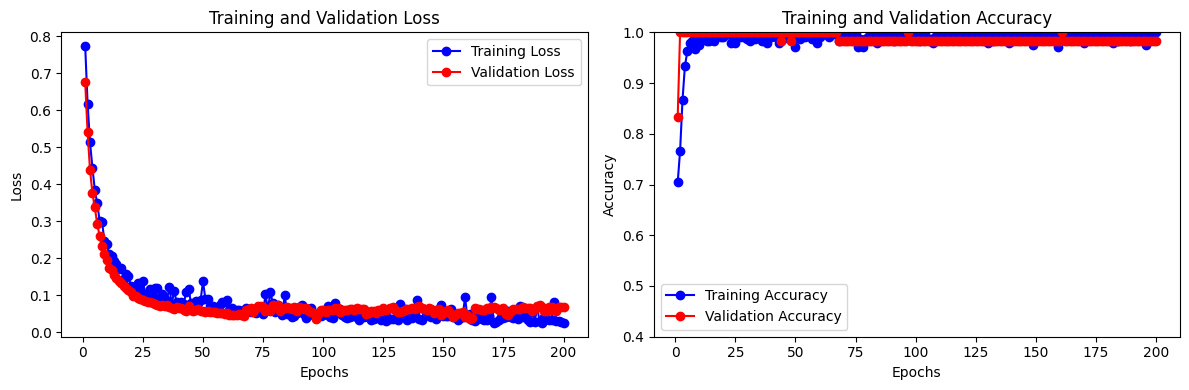

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      1.00      0.99        44
         out       1.00      0.94      0.97        16

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60

==========Cross Validation Fold 5==========
trainLoss: 0.8379 Acc: 0.0167
valLoss: 0.7622 Acc: 0.2000
trainLoss: 0.7159 Acc: 0.4292
valLoss: 0.6616 Acc: 0.2500
trainLoss: 0.6064 Acc: 0.9458
valLoss: 0.5788 Acc: 1.0000
trainLoss: 0.5161 Acc: 0.9917
valLoss: 0.5094 Acc: 1.0000
trainLoss: 0.4614 Acc: 0.9875
valLoss: 0.4490 Acc: 1.0000
trainLoss: 0.4210 Acc: 0.9958
valLoss: 0.4019 Acc: 1.0000
trainLoss: 0.3829 Acc: 0.9833
valLoss: 0.3659 Acc: 1.0000
trainLoss: 0.3533 Acc: 0.9917
valLoss: 0.3295 Acc: 1.0000
trainLoss: 0.3169 Acc: 0.9917
valLoss: 0.2995 Acc: 1.0000
trainLoss: 0.2963 Acc: 0.9958
valLoss: 0.2761 Acc: 1.0000
trainLoss: 0.2642 Acc: 0

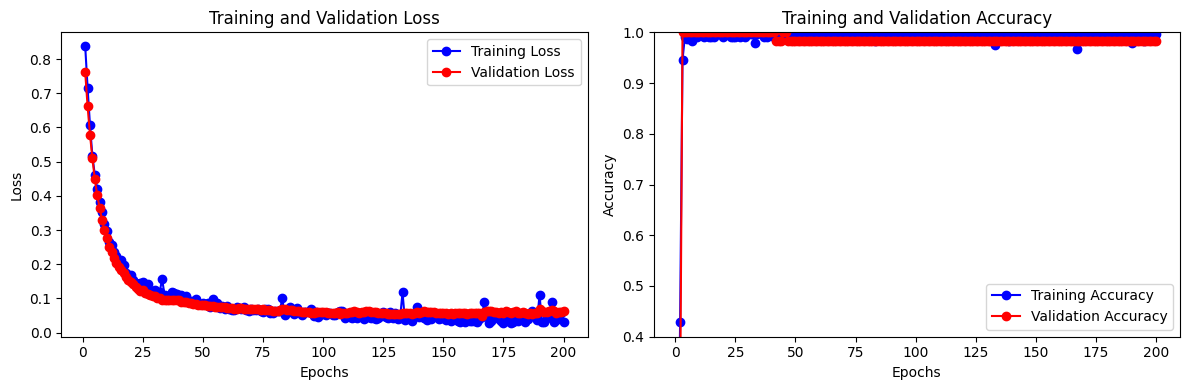

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      1.00      0.99        45
         out       1.00      0.93      0.97        15

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



In [12]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths,labels), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
    label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'


    image_paths, labels = update_xml_paths(image_directory, label_directory)
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.fc = nn.Linear(model.fc.in_features, 2)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    file_path = os.path.join(directory_path, f'{file_name}_{str(fold)}.pth')
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')
    model.load_state_dict(torch.load(file_path))
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())

    # 評価
    target_names = ['ok', 'out']  # クラス名をリストで指定
    print(classification_report(y_true, y_pred, target_names=target_names))